In [1]:
import os
import sys
from os import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
import json
import argparse
from scipy.optimize import least_squares
import coord_helper as ch
import h5py
import importlib

BDC is using numpy


In [6]:
config_file_name1 = 'config_mars_2024_day1.json'
config_file_name2 = 'config_mars_2024_day2.json'
baseline_idx =1 

In [7]:
with open(f"./config/{config_file_name1}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time1 = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)
print(global_start_time1)

Antenna Paths: ['/scratch/s/sievers/mohanagr/mars1_2024/baseband/', '/scratch/s/sievers/mohanagr/mars2_2024/baseband/']
Antenna Coordinates: [[79.41718333333333, -90.76735, 189], [79.41721666666666, -90.75885, 176]]
Visibility Accumulation Length 30000
Coarse Accumulation Length: 1000000
1721800002


In [8]:
with open(f"./config/{config_file_name2}", "r") as f:
    config2 = json.load(f)
    global_start_time2 = config2["correlation"]["start_timestamp"]
    
print(global_start_time2)

1721900002


In [9]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path = dir_parents[0]
a2_path = dir_parents[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path1 = outils.get_tle_file(global_start_time1, "/project/s/sievers/mohanagr/OCOMM_TLES")
tle_path2 = outils.get_tle_file(global_start_time2, "/project/s/sievers/mohanagr/OCOMM_TLES")


context = [visibility_window, T_SPECTRA, v_acclen, v_nchunks, ref_coords]

In [10]:
observed_data1 = []
info1 = []


#with h5py.File(f'vis_all_{global_start_time}_10hrs.h5', 'r') as f:

with h5py.File(f'vis_all_{global_start_time1}_10hrs.h5', 'r') as f:
    for pulse in f:
        # Access a dataset
        print(pulse)
        p = f[f'/{pulse}'].attrs['pulse_info']
        pulse_info = [[int(p[0]), int(p[1])], int(p[2]), int(p[3]), int(p[4]), global_start_time1, tle_path1]
        info1.append(pulse_info)
        data = f[f'/{pulse}'][:]
        observed_data1.append(data)
print(info1)
print(len(info1))

#possible to-do here is to order them by start time. but might not really matter.

10975_1836
10975_1837
17005_1836
17005_1837
22070_1841
22070_1850
23025_1836
23025_1837
23875_1836
23875_1837
27945_1849
27945_1850
28275_1841
29040_1836
29040_1837
29855_1836
29855_1837
31685_1836
31685_1837
34005_1849
34005_1850
34480_1841
35040_1836
4950_1836
4950_1837
7000_1836
7000_1837
715_1836
715_1837
715_1846
[[[10975, 11440], 59051, 1836, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[10975, 11440], 59051, 1837, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[17005, 17530], 59051, 1836, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[17005, 17530], 59051, 1837, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[22070, 22425], 25338, 1841, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[22070, 22425], 25338, 1850, 87178, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/

In [11]:
observed_data2 = []
info2 = []


#with h5py.File(f'vis_all_{global_start_time}_10hrs.h5', 'r') as f:

with h5py.File(f'vis_all_{global_start_time2}_10hrs.h5', 'r') as f:
    for pulse in f:
        # Access a dataset
        print(pulse)
        p = f[f'/{pulse}'].attrs['pulse_info']
        pulse_info = [[int(p[0]), int(p[1])], int(p[2]), int(p[3]), int(p[4]), global_start_time2, tle_path2]
        info2.append(pulse_info)
        data = f[f'/{pulse}'][:]
        observed_data2.append(data)
print(info2)
print(len(info2))

#possible to-do here is to order them by start time. but might not really matter.

12925_1841
13600_1849
13600_1850
14150_1836
14150_1837
14870_1836
14870_1837
17330_1836
17330_1837
18935_1841
19660_1849
19660_1850
20155_1836
20155_1837
20155_1850
20885_1836
20885_1837
2110_1836
2110_1837
26265_1836
26265_1837
26265_1850
26905_1836
26905_1837
29455_1836
29455_1837
30935_1841
30935_1846
31790_1850
32350_1836
32350_1837
32920_1836
32920_1837
32920_1838
35515_1836
35515_1837
6920_1841
8135_1836
8135_1837
[[[12925, 13380], 25338, 1841, 79705, 1721900002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240725.txt'], [[13600, 13905], 33591, 1849, 79730, 1721900002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240725.txt'], [[13600, 13905], 33591, 1850, 79705, 1721900002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240725.txt'], [[14150, 14695], 59051, 1836, 79731, 1721900002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240725.txt'], [[14150, 14695], 59051, 1837, 79731, 1721900002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/202407

In [12]:
good_pulse_idxs1 = [ 2, 4, 7, 11, 12, 17, 20, 24, 25, 27]
importlib.reload(ch)

<module 'coord_helper' from '/home/s/sievers/thomasb/albatros_analysis/scripts/orbcomm/fitting/coord_helper.py'>

In [13]:
pulse_data1 = [observed_data1[i] for i in good_pulse_idxs1]
pulse_info1 = [info1[i] for i in good_pulse_idxs1]
print(pulse_info1)
print(pulse_info1[0][0][0])

[[[17005, 17530], 59051, 1836, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[22070, 22425], 25338, 1841, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[23025, 23570], 59051, 1837, 48959, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[27945, 28075], 33591, 1850, 109994, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[28275, 28555], 25338, 1841, 86569, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[31685, 31985], 28654, 1836, 48958, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[34005, 34085], 33591, 1850, 86568, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[4950, 5270], 59051, 1837, 109993, 1721800002, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt'], [[7000, 7145], 28654, 1836, 109993, 1721800002, '/project/s/sie

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC


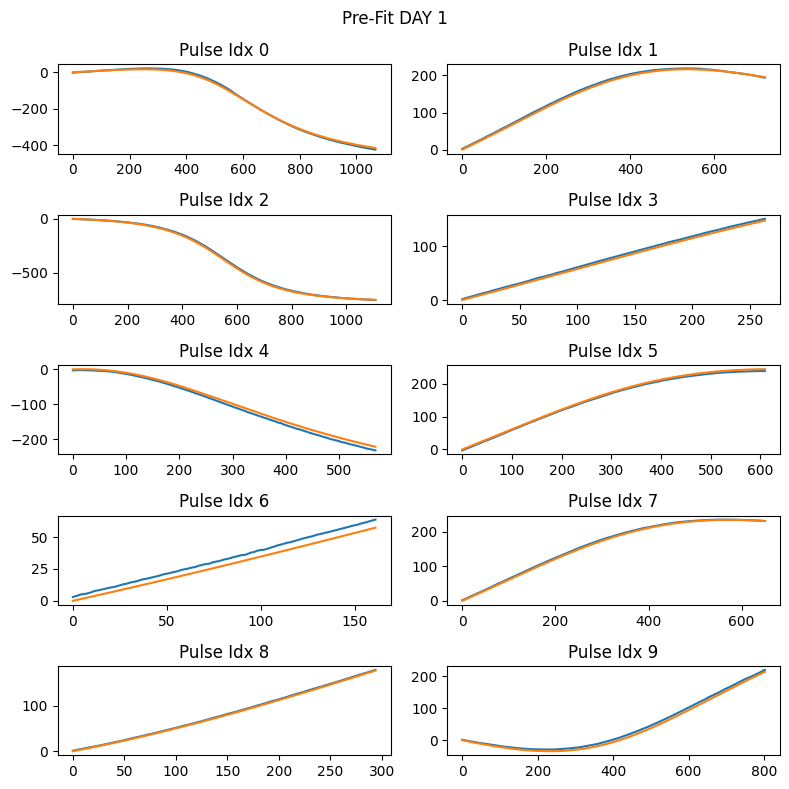

In [14]:
fig, ax = plt.subplots(int(np.ceil(len(pulse_data1)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit DAY 1")
for pulse_idx in range(len(pulse_data1)):
    predicted_data = ch.phase_pred(a2_coords, pulse_idx, pulse_info1, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data1[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

In [15]:
good_pulse_idxs2 = [0, 2, 4, 7, 8, 11,26, 28, 29, 30, 36, 38]

In [16]:
pulse_data2 = [observed_data2[i] for i in good_pulse_idxs2]
pulse_info2 = [info2[i] for i in good_pulse_idxs2]

catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC


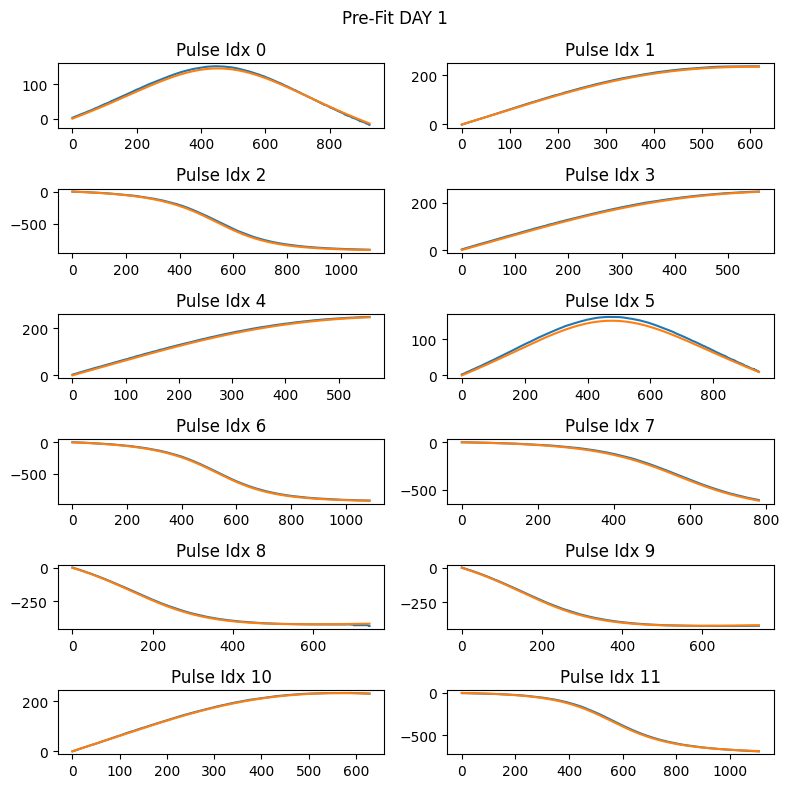

In [17]:
fig, ax = plt.subplots(int(np.ceil(len(pulse_data2)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit DAY 1")
for pulse_idx in range(len(pulse_data2)):
    predicted_data = ch.phase_pred(a2_coords, pulse_idx, pulse_info2, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data2[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

In [18]:
pulse_info = pulse_info1 + pulse_info2
pulse_data = pulse_data1 + pulse_data2

In [19]:
fit = ch.fitting_all(pulse_data, [79.41722193, -90.75888013, 182.76248769], ch.phase_pred, pulse_info, context, method='trf')

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #5

In [20]:
print(fit[0])
solid = fit[0]

[ 79.41722341 -90.75885658 183.41504506]


In [22]:
fit2 = ch.fitting_all_with_offsets(pulse_data, [79.41722193, -90.75888013, 182.76248769], ch.phase_pred, pulse_info, context, method='trf')

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #5

In [25]:
phased = fit2[0]
print(phased)

[ 79.41722441 -90.75887708 182.94474125]


In [26]:
ch.distance_calculator(phased, solid)

(0.43284279741573656, 0.4703038089749043)

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC


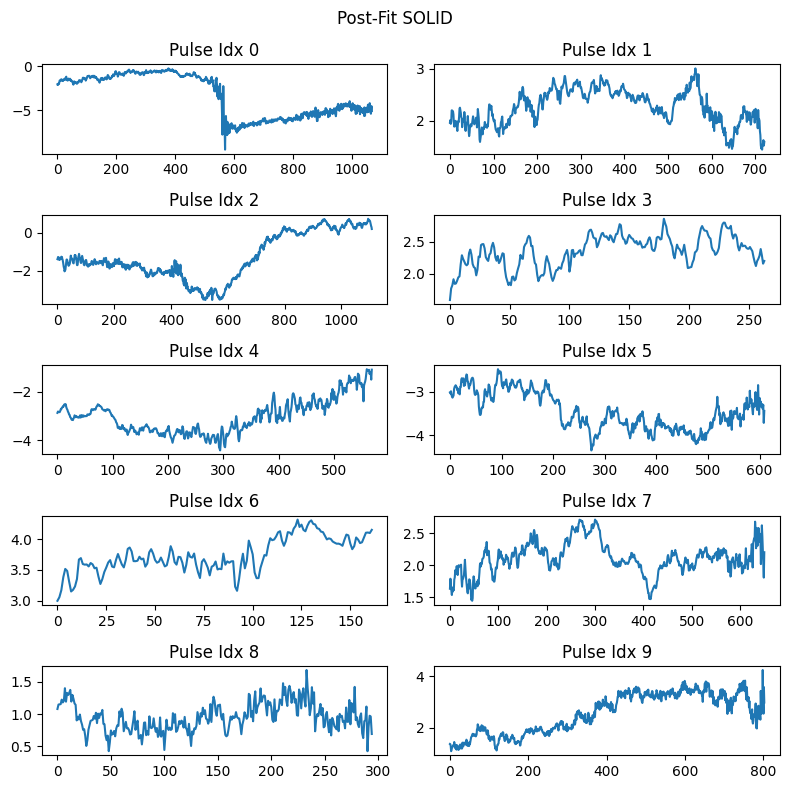

In [21]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Post-Fit SOLID")
for pulse_idx in range(10):
    predicted_data = ch.phase_pred(solid, pulse_idx, pulse_info, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data[pulse_idx] - predicted_data)
plt.tight_layout()

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC


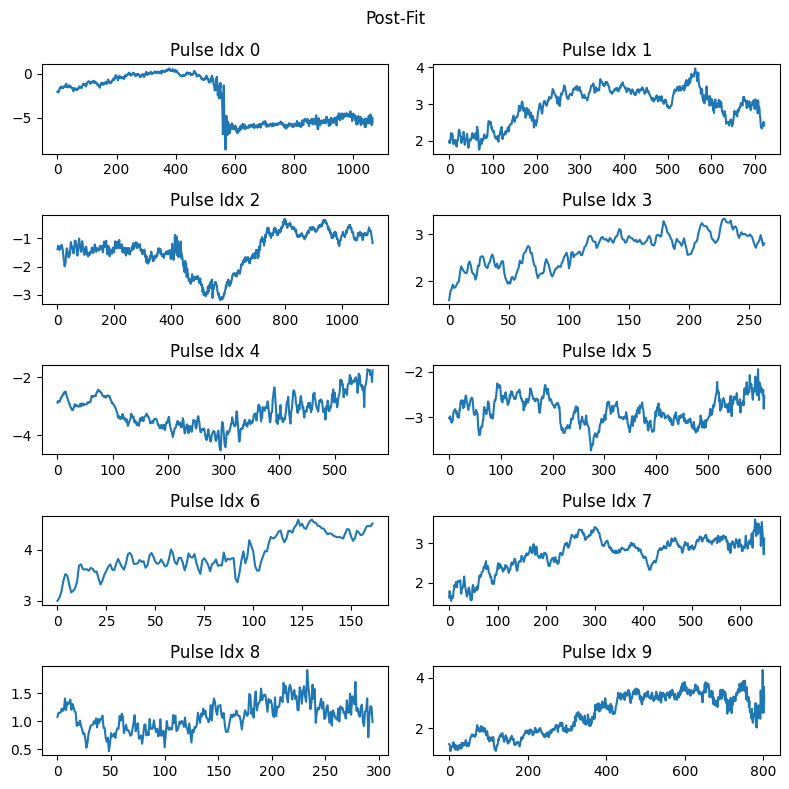

In [34]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Post-Fit")
for pulse_idx in range(10):
    predicted_data = ch.phase_pred(phased, pulse_idx, pulse_info, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(pulse_data[pulse_idx] - predicted_data)
plt.tight_layout()